In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Global seed set to 42


# Options for Unsupervised Training of Flexynesis

When an outcome variable is not available or it is desired to do an unsupervised training, the `supervised_vae` model in `flexynesis` can be utilized. 
The supervised variational autoencoder class can be trained on the input dataset without a supervisor head. If the user passes no target variables, batch variables, or survival variables, then the class behaves as a plain variational autoencoder. 

Flexynesis also comes with functions to cluster the samples by sample embeddings to facilitate downstream analysis. 

In [3]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 5 # number of HPO iterations for final modeling run

In [5]:
if not os.path.exists("singlecell_bonemarrow"):
    !wget -O singlecell_bonemarrow.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/singlecell_bonemarrow.tgz" && tar -xzvf singlecell_bonemarrow.tgz

In [6]:
data_importer = flexynesis.DataImporter(path ='singlecell_bonemarrow/', 
                                        data_types = ['RNA', 'ADT'], 
                                        concatenate=False, top_percentile=10, min_features=25)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing singlecell_bonemarrow/train/RNA.csv...
[INFO] Importing singlecell_bonemarrow/train/ADT.csv...
[INFO] Importing singlecell_bonemarrow/train/clin.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing singlecell_bonemarrow/test/RNA.csv...
[INFO] Importing singlecell_bonemarrow/test/ADT.csv...
[INFO] Importing singlecell_bonemarrow/test/clin.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame RNA - Removed 1875 features.
[INFO] Number of NA values:  0
[INFO] DataFrame ADT - Removed 0 features.
[INFO] DataFrame RNA - Remov

Filtering redundant features: 100%|██████████| 1513/1513 [00:02<00:00, 634.72it/s]


[INFO] Implementing feature selection using laplacian score for layer: ADT with  25 features
[INFO] No feature selection applied. Returning original matrix. Demanded # of features is  larger than existing number of features

[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame RNA - Removed 1800 features.
[INFO] Number of NA values:  0
[INFO] DataFrame ADT - Removed 0 features.
[INFO] DataFrame RNA - Removed 0 samples (0.00%).
[INFO] DataFrame ADT - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: RNA': 1419, 'feature_count in: ADT': 25, 'sample_count': 1000}
[INFO] Test Data Stats:  {

In [7]:
tuner = flexynesis.HyperparameterTuning(dataset = train_dataset, 
                                        model_class = flexynesis.supervised_vae, 
                                        target_variables = [],
                                        config_name = "supervised_vae", 
                                        plot_losses=True, early_stop_patience=10, 
                                        n_iter=HPO_ITER)    

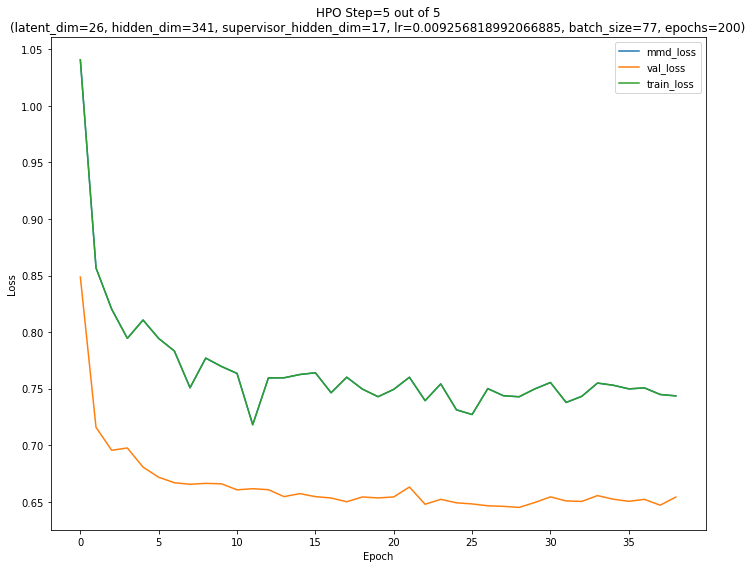

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.645. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         mmd_loss          │    0.6537238359451294     │
│         val_loss          │    0.6537238359451294     │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 5/5 [04:54<00:00, 58.86s/it, Iteration=5, Best Loss=0.638]


In [8]:
model, best_params = tuner.perform_tuning()

# Clustering and visualisation 

Now, we extract the sample embeddings from the test dataset, cluster the cells using Louivain clustering, and visualize the clusters along with known cell type labels. 

In [9]:
ds = test_dataset
E = model.transform(ds)

## Visualizing cells with known cell type labels 

In [10]:
#map the sample labels from numeric vector to initial labels. 
f = 'celltype_l2'
celltype_labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] 

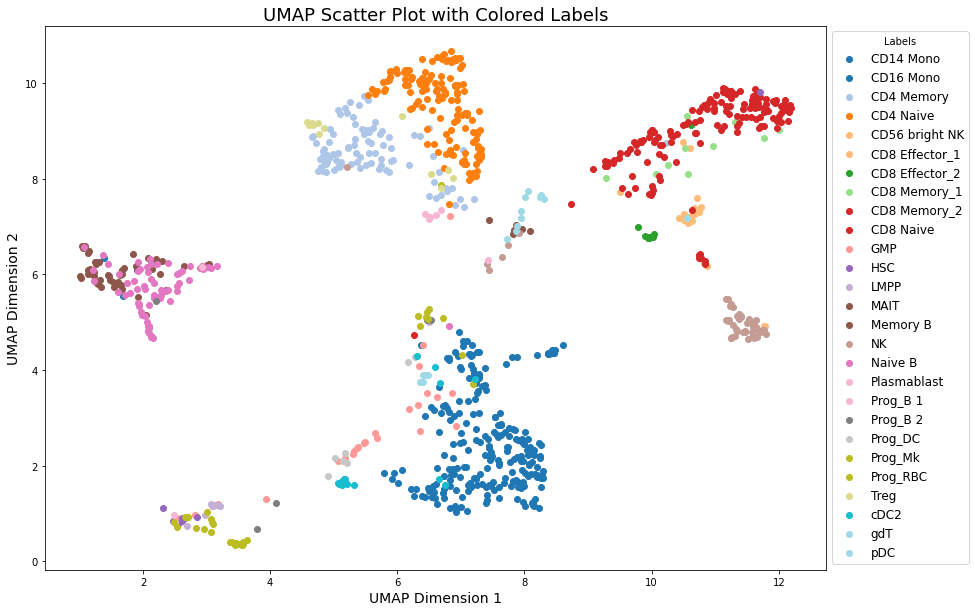

In [11]:
flexynesis.plot_dim_reduced(E, celltype_labels, color_type = 'categorical', method='umap', 
                            legend_kwargs={'loc': 'lower left', 'bbox_to_anchor': (1, 0), 'fontsize': 12},
                            figsize=(14, 10))

## Visualizing Unsupervised Clustering Labels

The sample embeddings can be clustered: 

In [12]:
cluster_labels, G, partition = flexynesis.louvain_clustering(E, k = 15) # try different values of k to get different clustering solutions

We can also use k-means clustering with a varying number of expected clusters and pick the best one based on silhouette scores:

In [13]:
kmeans_cluster_labels, optimal_k, silhouette_scores = flexynesis.get_optimal_clusters(E, min_k=10, max_k=20)

Compute the concordance (**AMI**: Adjusted Mutual Information; **ARI**: Adjusted Rand Index) between known cell type labels and unsupervised cluster labels.

In [14]:
flexynesis.compute_ami_ari(celltype_labels, cluster_labels)

{'ami': 0.7332604563588843, 'ari': 0.6318269079110258}

In [15]:
flexynesis.compute_ami_ari(celltype_labels, kmeans_cluster_labels)

{'ami': 0.6372039486515232, 'ari': 0.5372885584283188}

Louvain Clustering seems to yield better AMI/ARI scores. So, we use them to do more visualizations:

Plot UMAP using cluster labels: 

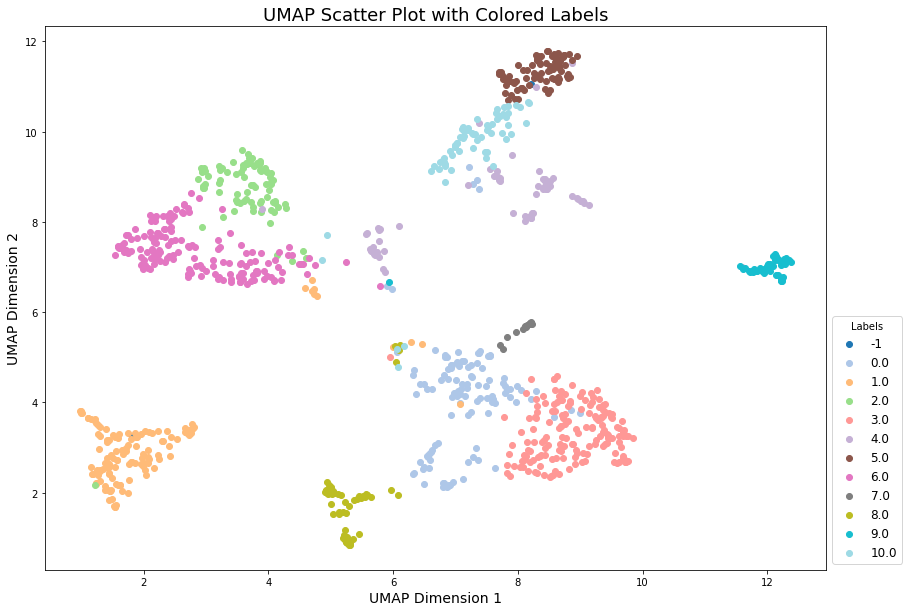

In [16]:
flexynesis.plot_dim_reduced(E, cluster_labels, color_type = 'categorical', method='umap', 
                            legend_kwargs={'loc': 'lower left', 'bbox_to_anchor': (1, 0), 'fontsize': 12},
                            figsize=(14, 10))

Observe a tabulation of the concordance between cell type labels and cluster labels. (Each row sums up to 1). 

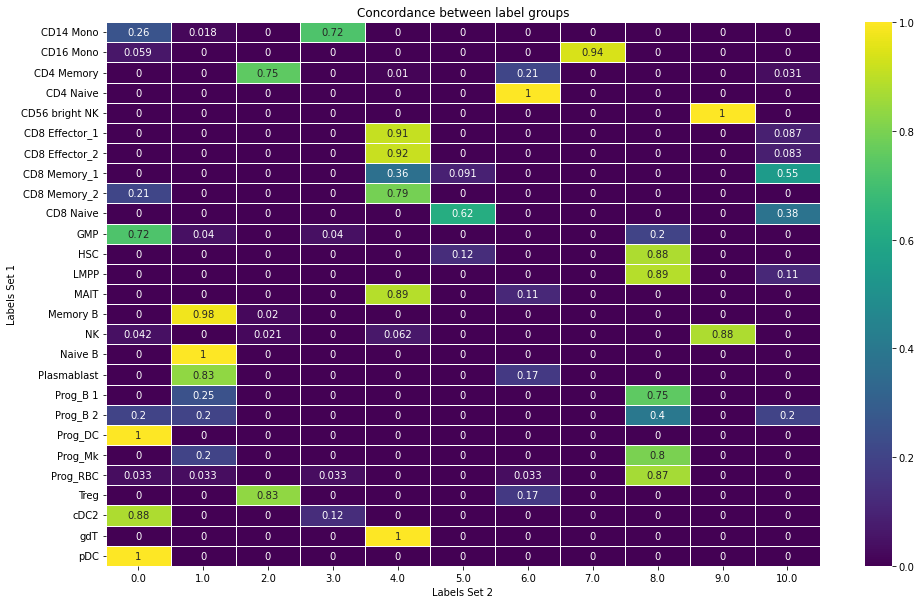

In [17]:
flexynesis.plot_label_concordance_heatmap(celltype_labels, cluster_labels, figsize=(16, 10))